In [8]:
from IPython.display import clear_output, display

import requests
from bs4 import BeautifulSoup
import json

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth', 400)
import numpy as np

import json
import time
import mouse
import os
from os.path import exists
import re
from win32api import GetSystemMetrics

from typing import Callable, Union
from collections.abc import Iterable



In [9]:
# Калибровка размера экрана для Selenium драйвера
def driver_screen_calibration(x, reverse=False):
    '''
    Корректировка координаты по x для драйвера (Иногда параметры экрана 
    для драйвера отличаются от параметров, которые видит система)
    '''
    if not reverse:
        new_x = x * (1596 + 7) / 1920 - 7
    else:
        new_x = (x + 7) * 1920 / (1596 + 7)
        
    return new_x


def search_query(driver, text: str = 'Магнит'):
    '''
    Для ввода поискового запроса в строку поиска
    '''
    input_text_element = driver.find_element(By.XPATH, 
                                             value="//input[@class='input__control _bold']")
    input_text_element.send_keys(Keys.CONTROL + "a");
    input_text_element.send_keys(Keys.DELETE);
    input_text_element.send_keys(text)
    input_text_element.send_keys(Keys.ENTER)
    

def form_geo_data_frame(snippet_elements: list):
    '''
    Парсим сниппеты для нахождения адреса и координат в рамках отображаемого куска карты
    '''
    # Парсим Адреса
    adress = [element.find_element(by=By.CLASS_NAME, 
                                   value='search-business-snippet-view__address')\
                                    .text\
                    for element in snippet_elements]
    # Парсим координаты
    coordinates = [element.find_element(by='xpath', 
                                        value='div')\
                        .get_attribute('data-coordinates').split(',') \
                    for element in snippet_elements]

    # Проверка соответствия длин
    assert len(adress) == len(coordinates), 'Длины списков не совпадают'

    # Формируем ДФ
    geo_df = pd.DataFrame({'adress': adress})
    geo_df[['lat', 'lon']] = coordinates
    
    return geo_df


def mouse_placer_decorator(func):
    def wrapper(*args, **kwargs):
        '''
        Декоратор для приведения мыши к нужной зоне
        '''
        x, y = mouse.get_position()
        mouse.move(WIDTH * 0.75, 
                   0, 
                   absolute=True, 
                   duration=0)
        mouse.click()
        # Декорируемая функция
        func(*args, **kwargs)
        mouse.move(x, 
                   y, 
                   absolute=True, 
                   duration=0)
        
    return wrapper

@mouse_placer_decorator
def decrease_win_scale(iterations=5):    
    '''
    Костыль для уменьшения масшатаба окна
    '''
    import keyboard
    
    for i in range(iterations):
        keyboard.press_and_release('ctrl+-')


def get_coordinates(url:str):
    '''
    Экстрактим координаты центра карты из фильтра для адреса страницы
    '''
    if 'https://yandex.ru/map' in url:
        coordinates_pair = re.search(r'[\?&]ll=(.{5,30})&', url)
        coordinates_pair = coordinates_pair.group(1)
        
        return coordinates_pair.split('%2C')
    
    else:
        print('Не тот URL')
        
        
def get_zoom_value(url):
    '''
    Экстрактим значение зума из фильтра для адреса страницы
    '''
    if 'https://yandex.ru/map' in url:
        zoom_value = re.search(r'[\?&]z=(\d{1,3}\.?\d{0,2})', url)
        zoom_value = zoom_value.group(1)
        
        return zoom_value
    
    else:
        print('Не тот URL')


def get_delta_info(driver):
    '''
    Функция для определения 
    '''
    # Определяем координаты центра карты до смещения
    lat_curr, lon_curr = tuple(map(lambda x: float(x), 
                               get_coordinates(driver.current_url)))
    
    # Получаем необходимые параметры элементов страницы
    coords = driver.get_window_position(windowHandle='current')
    sidebar_width = driver.find_element(by=By.CLASS_NAME, 
                                         value='sidebar-view__panel').size['width']
    map_height, map_width = driver.find_element(by=By.CLASS_NAME, 
                               value='map-container').size.values()

    delta_y, delta_x = map(lambda x: driver_screen_calibration(x*0.5*0.5,
                                                               reverse=True)//100*100, 
                           (map_height, map_width))

    # Двигаем мышь на центр объекта карты
    mouse.move(driver_screen_calibration(coords['x'] + (sidebar_width + map_width*0.5)*0.5, 
                                         reverse=True), 
               HEIGHT * 0.5, 
               absolute=True, 
               duration=0)  # Задаем элементы условия для цикла

    driver_screen_calibration(map_width*0.5*0.5, reverse=True)

    # Перетаскиваем на N пикселей
    mouse.hold()
    time.sleep(1)
    mouse.drag(0, 0, 
               -delta_x, delta_y, 
               absolute=False, duration=3.7)
    time.sleep(1)
    
    # Определяем координаты центра карты после смещения
    lat_new, lon_new = tuple(map(lambda x: float(x), 
                           get_coordinates(driver.current_url)))
    
    # Определяем дельту смещения
    lat_delta = (lat_new - lat_curr) * 2
    lon_delta = (lon_new - lon_curr) * 2

    return lat_delta, lon_delta


def replace_filter_value(url:str, 
                         new_value: Union[int], 
                         filter_text:str, 
                         get_function: Callable[[str], str]):
    '''
    Для замены значений у фильтров
    '''
    # Проверям входное значение и оборачиваем в список, если не в списке
    if not isinstance(new_value, Iterable):
        new_value = [new_value]
        
    # Парсим текущее значение фильтра
    current_value = get_function(url)
    
    # Оборачиваем в список, если нужно
    if not isinstance(current_value, Iterable)\
        or isinstance(current_value, str):
        current_value = [current_value]
    
    # Замена значений в выбранном фильтре
    new_url = url.replace(filter_text.format(*current_value),
                        filter_text.format(*new_value))
    
    return new_url


def move_to_url(driver,
                lon_lat, 
                zoom=12,
                url_with_filters='https://yandex.ru/maps/?ll=50%2C80&z=10'):
    '''
    Переходит по адресу с заданными координатами и значением приближения
    '''
    # Задаются дефолтные значения url и фильтров
    coordinate_filter_text = 'll={}%2C{}'
    zoom_filter_text = 'z={}'
    
    # Подставляем значения широты и долготы 
    start_point_url = replace_filter_value(url=url_with_filters,
                                             new_value=lon_lat,
                                             filter_text=coordinate_filter_text,
                                             get_function=get_coordinates)
    # Подставляем значения зума
    start_point_url = replace_filter_value(url=start_point_url,
                                             new_value=zoom,
                                             filter_text=zoom_filter_text,
                                             get_function=get_zoom_value)
    
    # Возвращаем сформированный адрес
    return start_point_url


def mouse_placer_for_scroler_decorator(func):
    def wrapper(*args, **kwargs):
        '''
        Декоратор для позиционирования курсора для скролинга
        '''
        # Активируем окно и двигаем мышь в нужную область 
        mouse.move(driver_screen_calibration(WIN_POSITION_X + WIN_WIDTH*0.5, 
                                             reverse=True), 
                   0, 
                   absolute=True, 
                   duration=0)
        mouse.click()
        
        # Определяем координаты зоны для скролинга
        coords = driver.get_window_position(windowHandle='current')
        sidebar_length = driver.find_element(by=By.CLASS_NAME, 
                                             value='sidebar-view__panel')\
                                .size['width']
        
        # Двигаем мышь на место прокрутки
        mouse.move(driver_screen_calibration(coords['x'] + sidebar_length*0.5*0.5, 
                                             reverse=True), 
                   HEIGHT * 0.5, 
                   absolute=True, 
                   duration=0.1)# Задаем элементы условия для цикла
        time.sleep(2)
        
        return func(*args, **kwargs)
    
    return wrapper


@mouse_placer_for_scroler_decorator
def gather_all_snippets(driver):
    '''
    Автоматизация для прокрутки скроллбара и сбора данных по каждой найденной точке
    '''
    global snippet_elements
    
    # Подготовка элементов для условия цикла
    prev_len = 0
    snippet_elements = driver.find_elements(by=By.CLASS_NAME, 
                                            value='search-snippet-view')
    curr_len = len(snippet_elements)

    # Лупим прокрутку до тех пор, пока не перестанут подгружаться новые сниппеты
    while curr_len != prev_len:
        clear_output()
        print('Количество загруженных точек', curr_len)
        # Прокрутка
        mouse.wheel(delta=-200)
        time.sleep(1)
        # ПроверОчка

        # Луп с проверкой статуса подгрузки новых точек
        counter = 0
        loading = bool(driver.find_elements(by=By.CLASS_NAME, 
                         value='search-list-view__spinner-text'))
        while loading and counter <= 5:
            time.sleep(1)
            counter += 1
            # Статус загрузки
            loading = bool(driver.find_elements(by=By.CLASS_NAME, 
                     value='search-list-view__spinner-text'))

        # Обновляем список элементов
        snippet_elements = driver.find_elements(by=By.CLASS_NAME, 
                                                value='search-snippet-view')
        # Обновляем элементы условия
        prev_len, curr_len = curr_len, len(snippet_elements)

    # Формируем ДФ с адресом и координатами
    geo_df = form_geo_data_frame(snippet_elements)
    
    return geo_df


# Задаем константные параметры
WIDTH = GetSystemMetrics(0)
HEIGHT = GetSystemMetrics(1)
DRIVER_WIDTH = driver_screen_calibration(WIDTH) + 7
DRIVER_HEIGHT = driver_screen_calibration(HEIGHT) + 7

WIN_POSITION_X = driver_screen_calibration(WIDTH * 0.4)
WIN_POSITION_Y = 0

WIN_WIDTH = DRIVER_WIDTH - WIN_POSITION_X
WIN_HEIGHT = DRIVER_HEIGHT * 0.95

In [10]:
# Настраиваем опции драйвера
options = webdriver.ChromeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")

# Подключаем драйвер
driver = webdriver.Chrome(options=options)
driver.set_window_size(WIN_WIDTH, 
                       WIN_HEIGHT)

# Переходим на сайт настраиваем окно
url = 'https://yandex.ru/maps/'
driver.set_window_position(WIN_POSITION_X, 
                           WIN_POSITION_Y, 
                           windowHandle='current')

# Переходим на страницу яндекс карт
driver.get(url)

# Уменьшим масштаб окна
decrease_win_scale(iterations=5)

# driver.execute_script("document.body.style.zoom='50%'")

In [11]:
current_url = driver.current_url
new_value = 8
filter_text = 'z={}'
get_function = get_zoom_value

replace_filter_value(url=current_url,
                     new_value=new_value,
                     filter_text=filter_text,
                     get_function=get_function)

12
['12']


'https://yandex.ru/maps/213/moscow/chain/magnit/35471869327/?ll=37.655921%2C55.750458&sll=37.617700%2C55.755863&sspn=1.962433%2C1.024585&z=8'

In [24]:
current_url = driver.current_url
new_value = [22, 11]
filter_text = 'll={}%2C{}'
get_function = get_coordinates

replace_filter_value(url=current_url,
                     new_value=new_value,
                     filter_text=filter_text,
                     get_function=get_function)

'https://yandex.ru/maps/213/moscow/?ll=22%2C11&z=6'

In [ ]:
d

In [59]:
# Переход на нужную координату

lon_lat = [39, 55]
zoom = 12

# Определяем URL для стартовой точки
start_point_url = move_to_url(driver=driver, lon_lat=lon_lat)
# Переходим на стартовую точку
driver.get(start_point_url)

In [15]:
# Калибровка для определения оптимального значения зума
lon_lat = [37.6, 55.75]
init_zoom = 12
# iteration_num = 2

# Ищем сеть
search_query(driver=driver, text='Магнит')
time.sleep(2)

for zoom_value in range(init_zoom, 16):
    # Переходим по указанным координатам с текущим зумом
    new_url = move_to_url(driver=driver,
                            lon_lat=lon_lat, 
                            zoom=zoom_value,
                            url_with_filters=driver.current_url)
    driver.get(new_url)
    
    # Создаем список-болванку для фиксации размера датасета
    amount_list = []
    
    for i in range(2):
        # Собираем данныaе с текущим зумом
        brand_df = gather_all_snippets(driver=driver)
        
        # Добавляем к списку длину датасета
        amount_list.append(len(brand_df))
        
        # Обновляем страницу для следующей итерации
        driver.refresh()
        time.sleep(2)
    
    # Условие для раннего выхода из цикла
    if len(set(amount_list)) == 1:
        break

print('Рекомендуемое значение зума: ', zoom_value)

Количество загруженных точек 25
Рекомендуемое значение зума:  14


In [11]:
topleft_lon_lat = [37.6, 55.75]
bottomright_lon_lat = [39, 55]
delta_coef = 0.8
zoom = 12
file_name = 'geo_data.csv'


# Определяем URL для стартовой точки
start_point_url = move_to_url(driver=driver, 
                              lon_lat=topleft_lon_lat)
# Переходим на стартовую точку
driver.get(start_point_url)
# Получаем значения шага по широте и долготе для перехода на новый квадрат
delta_lon_lat = get_delta_info(driver)
# Корректировка шага при помощи коэффициента delta_coef
delta_lon_lat = tuple(map(lambda x: x * delta_coef, delta_lon_lat))

# Возвращаемся на стартовую точку
driver.get(start_point_url)

# Ищем сеть
search_query(driver=driver, text='Магнит')
time.sleep(2)
current_url = driver.current_url

# Определяем URL для стартовой точки
start_point_url = move_to_url(driver=driver, 
                              lon_lat=topleft_lon_lat,
                              url_with_filters=current_url)
# Переходим на стартовую точку
driver.get(start_point_url)

# Фиксируем исходное значение по долготе
current_lon_bkp = topleft_lon_lat[0]
# Распределяем данные из списка
current_lon, current_lat = topleft_lon_lat
delta_lon, delta_lat = delta_lon_lat
finish_lon, finish_lat = bottomright_lon_lat

# Цикл по широте
while current_lat > finish_lat - delta_lat:
    current_lon = current_lon_bkp
    # Цикл по долготе
    while current_lon < finish_lon + delta_lon:
        # Переходим на страницу следующего квадрата
        print(current_lon, current_lat)
        new_url = move_to_url(driver=driver, 
                                lon_lat=[current_lon, current_lat],
                                url_with_filters=driver.current_url)
        driver.get(new_url)
        time.sleep(2)
        # Собираем информацию о магазинах с прогруженного квадрата карты
        brand_df = gather_all_snippets(driver)
        # Сохраняем собранные данные
        brand_df.to_csv(file_name, 
                           mode='a' if exists(file_name) else 'w', 
                           sep='\t', 
                           index=False,
                           header = not exists(file_name))

        
        
        current_lon += delta_lon 
        
    current_lat -= delta_lat

Количество загруженных точек 25


In [18]:
driver.refresh()

In [12]:
magnit_msk_df = gather_all_snippets(driver=driver)

Количество загруженных точек 25


In [13]:
magnit_msk_df

,adress,lat,lon
0,"ул. Жуковского, 6А, Луховицы",39.023122,54.949200
1,"ул. Жуковского, 38А, Луховицы",39.034460,54.943639
2,"23, посёлок Сельхозтехника",39.181648,54.956437
3,"Первомайская ул., 49, корп. 1, Луховицы, этаж 1, помещение XXI",39.029795,54.966773
4,"ул. Пушкина, 153Б, Луховицы, этаж 1, помещение №1, комната №1",39.017339,54.949329
5,"ул. Пушкина, 100, Луховицы",39.029385,54.972198
6,"ул. Пушкина, 143, Луховицы, 1:.4-9.11-13, комната №1.2",39.019446,54.953301
7,"ул. Дзержинского, 10, Коломна, помещение 2",38.804551,55.079221
8,"Окская ул., 142А, село Пирочи, этаж 1, помещение №I, комната №1-3, 8, 9",38.957074,55.075146
9,"Центральная ул., 19, посёлок Газопроводск",39.229442,54.837094


In [53]:
# Очищаем и вбиваем значения (сеть + адрес + координаты)
# Индекс в ДФ
df_index = 0

# Текст запроса
text_to_send = 'Магнит ' + ' '.join(geo_df.iloc[df_index].tolist())
print(text_to_send)

# Ищем конкретную точку
# search_query(text_to_send)


Магнит Тверская ул., 6, стр. 1, стр. 1, этаж -1 37.610681 55.760920


In [4]:
# Ищем сеть
search_query(driver=driver, text='Магнит')
time.sleep(2)

# Собираем данныaе с текущего положения карты
magnit_msk_df = gather_all_snippets(driver=driver)

In [8]:
res = pd.DataFrame(columns=magnit_msk_df.columns)

218
218


array([[<AxesSubplot: title={'center': 'cnt'}>]], dtype=object)

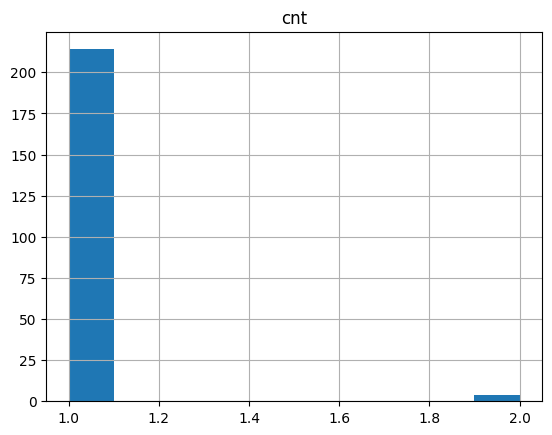

In [9]:
b = res.assign(res_cnt=1)\
        .merge(magnit_msk_df.assign(cnt=1), 
               on=['adress', 'lat', 'lon'], 
               how='right')
print(len(b[b['res_cnt'].isna()].drop_duplicates()))
res = pd.concat([res, magnit_msk_df])
cnt = res.copy()
cnt['cnt'] = 1
a = cnt.groupby(by=['adress', 'lat', 'lon'], as_index=False).count()
print(len(a))

a.hist('cnt')

In [14]:
log = driver.get_log("browser")
log

log[-1]['message'].split('=')

['https://yandex.ru/maps/213/moscow/chain/magnit/35471869327/?ll',
 '37.669173%2C55.747217&sll',
 '37.617700%2C55.755863&sspn',
 '1.962433%2C1.024585&z',
 "12 - The resource https://frontend.vh.yandex.ru/stable/player_version/player.js was preloaded using link preload but not used within a few seconds from the window's load event. Please make sure it has an appropriate `as` value and it is preloaded intentionally."]